# Writing a training loop from scratch
https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch

## Import libraries

In [1]:
# Python libraries
import os
import pandas as pd # for data manipulation
import numpy as np # for data manipulation
import tensorflow as tf
import matplotlib.pyplot as plt

# To enable LaTeX and select a font
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

# Using ipynb import functions defined in other nb
from ipynb.fs.defs.myfun_load_dataset import *
from ipynb.fs.full.myfun_models import *
from ipynb.fs.full.myfun_nn import *
from ipynb.fs.defs.myfun_plot import *

2023-08-29 10:56:19.069111: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Tensorflow/Keras: 2.11.0
sklearn: 1.3.0


## Data Acquisition

In [2]:
# Load the dataset
par_dir = os.path.dirname(os.getcwd()) # parent dir
dir_name = par_dir + "/NN-interaction"
merged_df, dflist = load_dataset(dir_name, 'post')

## Create the model NN

In [3]:
# Create the model
DOE =[[1,2,1]] #Design of experiment
model = create_model(DOE[0])

### What do trainable variables and trainable weights mean?

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden-Layer-1 (Dense)      (None, 2)                 4         
                                                                 
 Output-Layer (Dense)        (None, 1)                 3         
                                                                 
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________


In [5]:
len(model.trainable_variables), len(model.trainable_weights)

(4, 4)

In [6]:
for var in model.trainable_variables:
    print(f"{var.name}:\t {var.numpy().flatten()}")

Hidden-Layer-1/kernel:0:	 [-0.04919791  0.20187187]
Hidden-Layer-1/bias:0:	 [ 0.70679903 -0.36817145]
Output-Layer/kernel:0:	 [ 0.3140986  -0.37290597]
Output-Layer/bias:0:	 [-0.8365915]


## Training loop

In [7]:
# Create the dataset using scene
df = dflist[0]
scn_list = seq2scn(df)
dataset = scn_list[:1]

In [8]:
## For NN training
NUM_EPOCHS = 100
deltat = 0.05
# Optimizer
LEARNING_RATE_NN = 0.01
optimizer = tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE_NN)

# Instantiate a loss function.
loss_fn = tf.keras.losses.MeanSquaredError()

In [9]:
## For optimizing v0
loss_objective = tf.keras.losses.MeanSquaredError()


Step n. 0
----------------------------------------------------------------------------------------------------
Scene n. 0, time interval: [14.24,14.64]


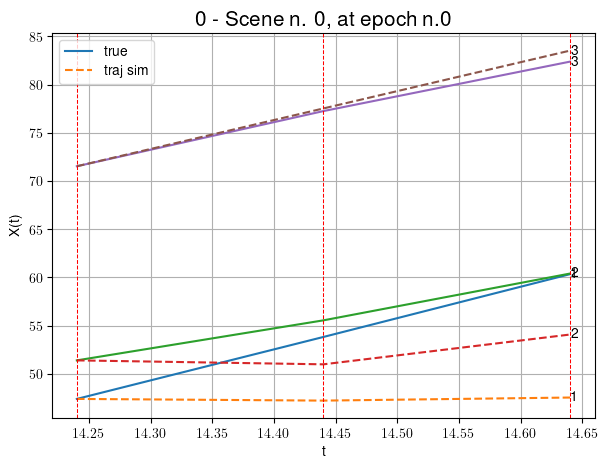

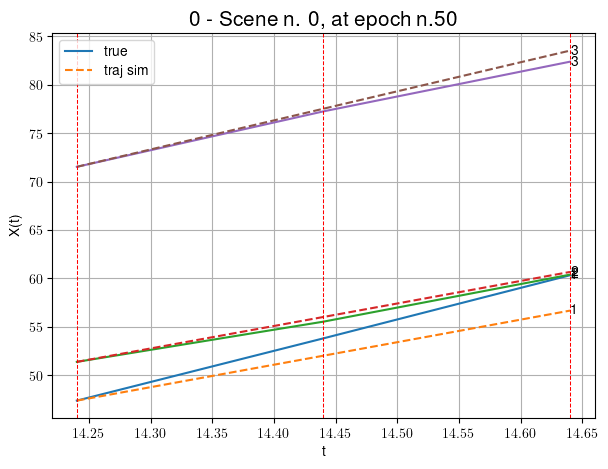

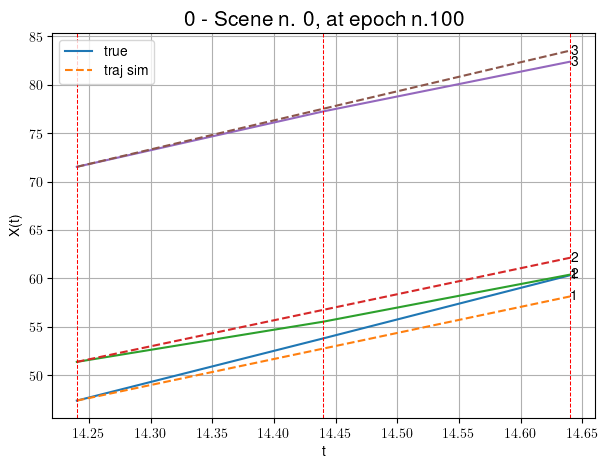

In [10]:
v0 = 30

for step, scn in enumerate(dataset):
    print("=="*50)
    print(f"\nStep n. {step}")
    
    N, tstamps = scn['N. vehicles'], scn['Tarr']
    formatter = '{0:.02f}'

    print("--"*50)
    print(f"Scene n. {scn.name}, time interval: [{formatter.format(tstamps[0])},{formatter.format(tstamps[-1])}]")

    for epoch in range(NUM_EPOCHS+1):
                
        x_list, t_list, v_list = [[i] for i in scn['Xarr'][:,0]], [scn['Tarr'][0]], []
        X_arr, y_arr = create_data_ann_scene(scn)
        
        for i in range(0,len(tstamps)-1):

            ## STEP 1: Create the dataset and train the nn model
            X, y = X_arr[:,i], y_arr[:,i]
            
            with tf.GradientTape(persistent=True) as tape:

                # Create tensor that you will watch
                x_tensor = tf.convert_to_tensor(X, dtype=tf.float64)
                tape.watch(x_tensor)

                y_pred = model(X, training=True) # forward pass
                loss_value = loss_fn(y_true = y, y_pred = y_pred) # loss function

            # Compute gradients
            trainable_vars = model.trainable_variables
            grads = tape.gradient(loss_value, trainable_vars)

            # Update weights
            optimizer.apply_gradients(zip(grads, trainable_vars))
            
#         print_grads(model, grads) # plot the last grads wrt trainable vars

            ## STEP 2: Solve the ODE sys in this time interval
            x0 = [l[-1] for l in np.vstack(x_list).tolist()]  # last values computed
            t0, tend = scn['Tarr'][i], scn['Tarr'][i+1]
            v_ann = np.append(y_pred.numpy().flatten().tolist(),v0).tolist()
            tspan_ann, sol_ann = odesolver_ann(x0, v_ann, t0, tend, deltat)

            ## STEP 2: Store the info
            x_list, t_list = update_sol_lists(N, tspan_ann, sol_ann, x_list, t_list)
            v_list.append(v_ann)
  
        # plot function
        if epoch % 50 == 0:
            t_ann_matched, trajs_ann_matched = match_timestamps_scene(t_list, x_list)
            tscale = 1+(tstamps[-1]-tstamps[0])/10000
            title = f"{step} - Scene n. {scn.name}, at epoch n.{epoch}"
            plot_scn(scn, trajs_ann_matched, title, xbal=0.01, ybal=0.05, scale=tscale)

    print("=="*50)

## Using myfun_models, only the last plot

In [11]:
v0 = 30
LEARNING_RATE_NN = 0.01

In [12]:
t_list2, x_list2, v_list2 = solve_nn_scn_custom(model, scn, v0, LEARNING_RATE_NN)

We have 2 time intervals inside [14.24,14.64]

----------------------------------------------------------------------------------------------------
Time interval n.0: [14.24, 14.44]

        * X: [ 3.99873573 20.14052405]
        * y_true: [32.1443344  20.77111865]
        * y_pred: [26.899824142456055, 26.899274826049805]
        * v_ann: [26.899824142456055, 26.899274826049805, 30.0]

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Time interval n.1: [14.44, 14.64]

        * X: [ 1.72409258 21.71186802]
        * y_true: [32.5721373  24.27162308]
        * y_pred: [26.924306869506836, 26.890438079833984]
        * v_ann: [26.924306869506836, 26.890438079833984, 30.0]

----------------------------------------------------------------------------------------------------


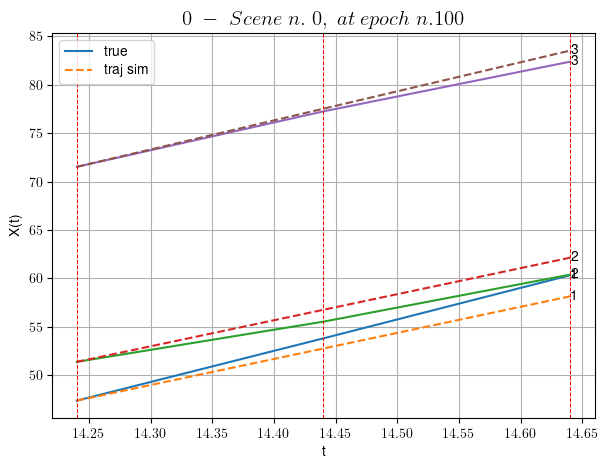

In [15]:
t_ann_matched2, trajs_ann_matched2 = match_timestamps_scene(t_list2, x_list2)
tscale = 1+(tstamps[-1]-tstamps[0])/10000
title = f"${step}\ -\ Scene\ n.\ {scn.name},\ at\ epoch\ n.{epoch}$"
plot_scn(scn, trajs_ann_matched2, title, xbal=0.01, ybal=0.05, scale=tscale)